# vaxxAId

**VaxxAId** aims to cluster and find similarities among patients who experienced COVID-19 vaccine adverse reactions or side effects based on the reports from the Vaccine Adverse Event Reporting System (VAERS). This would aid in the identification and classification of patients at risk of such effects. It will use the **K-modes clustering algorithm** to cluster the reports based on features such as patient outcomes, demographics, type of vaccine received, etc.

## Loading the datasets

In [3]:
# Load the datasets

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import ipynb.fs.defs.utils as utils


patients = pd.read_csv('../data/2021VAERSDATA.csv', encoding='latin1')
vaccine = pd.read_csv('../data/2021VAERSVAX.csv', encoding='latin1')

# patients = pd.concat([patients2021, patients2022], axis=0)
# vaccine = pd.concat([vaccine2021, vaccine2022], axis=0)


# Joining the datasets on VAERS_ID

patients = patients.join(vaccine.set_index('VAERS_ID'), on='VAERS_ID', how='inner')

# Keep only the following columns

features = ['VAERS_ID','STATE','AGE_YRS','SEX','DIED','L_THREAT','ER_VISIT','HOSPITAL','DISABLE','BIRTH_DEFECT','RECOVD','V_ADMINBY','VAX_TYPE','VAX_MANU','VAX_SITE','VAX_ROUTE']
patients = patients[features]

# Keep only reports on COVID19 vaccine

patients = patients[patients['VAX_TYPE']=='COVID19']

# Drop VAX_TYPE column

patients = patients.drop(['VAX_TYPE'],axis=1)

patients


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14748\1994910184.py:11: DtypeWarning: Columns (7,12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  patients = pd.read_csv('../data/2021VAERSDATA.csv', encoding='latin1')


,VAERS_ID,STATE,AGE_YRS,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,RECOVD,V_ADMINBY,VAX_MANU,VAX_SITE,VAX_ROUTE
0,916600,TX,33.0,F,NaN,NaN,NaN,NaN,NaN,NaN,Y,PVT,MODERNA,LA,IM
1,916601,CA,73.0,F,NaN,NaN,NaN,NaN,NaN,NaN,Y,SEN,MODERNA,RA,IM
2,916602,WA,23.0,F,NaN,NaN,NaN,NaN,NaN,NaN,U,SEN,PFIZER\BIONTECH,LA,IM
3,916603,WA,58.0,F,NaN,NaN,NaN,NaN,NaN,NaN,Y,WRK,MODERNA,NaN,NaN
4,916604,TX,47.0,F,NaN,NaN,NaN,NaN,NaN,NaN,N,PUB,MODERNA,LA,IM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34116,1113917,FL,88.0,F,NaN,NaN,NaN,Y,NaN,NaN,U,UNK,MODERNA,NaN,OT
34117,1113920,PA,83.0,F,NaN,NaN,NaN,NaN,NaN,NaN,Y,UNK,PFIZER\BIONTECH,NaN,NaN
34118,1113963,MS,59.0,F,Y,NaN,NaN,NaN,NaN,NaN,N,PVT,PFIZER\BIONTECH,NaN,NaN
34119,1115045,AZ,57.0,M,Y,NaN,NaN,NaN,NaN,NaN,N,UNK,MODERNA,NaN,OT


Described in the following table are the attributes for the clustering process. All of these are categorical data.

| Attributes | Data Type | Description |
| ---------- | --------- | ----------- |
| `STATE`        | char(2)   | Home state of the vaccinee                                  |
| `AGE_GRP`      | range     | Age group                                                   |
| `SEX`          | char(1)   | Sex                                                         |
| `DIED`         | char(1)   | Adverse effect caused death of the patient                  |
| `L_THREAT`     | char(1)   | Life-threatening event associated with the vaccination      |
| `ER_VISIT`     | char(1)   | Patient required ER visit after experiencing adverse effect |
| `HOSPITAL`     | char(1)   | Patient was hospitalized after experiencing adverse effect  |
| `DISABLE`      | char(1)   | Patient was disabled after experiencing adverse effect      |
| `BIRTH_DEFECT` | char(1)   | Patient has birth defect                                    |
| `RECOVD`       | char(1)   | Patient recovered from adverse effect                       |
| `V_ADMINBY`    | char(3)   | Vaccine administered at                                     |
| `VAX_MANU`     | char(40)  | Vaccine manufacterer                                        |
| `VAX_SITE`     | char(6)   | Vaccination anatomic site                                   |
| `VAX_ROUTE`    | char(6)   | Vaccine route of administration                             |

## Replacing null values

In [4]:
def replace_values(df):
    df['STATE'] = df['STATE'].str.upper()

    # Add a new column, AGE_GRP, and drop AGE_YRS
    age_max = df['AGE_YRS'].max()
    multiplier = 10 ** -1
    age_max= int(math.ceil(age_max * multiplier) / multiplier)
    age_grp = [i for i in range(0,age_max+1,10)]
    df['AGE_GRP'] = pd.cut(x=df['AGE_YRS'], bins=age_grp).astype(str)
    df = df.drop(['AGE_YRS'],axis=1)

    # Fill na with the following corresponding unknown values
    values = {'STATE': 'NA', 'RECOVD': 'U', 'DIED': 'N', 'L_THREAT': 'N', 'ER_VISIT': 'N', 'HOSPITAL':'N', 'DISABLE':'N', 'BIRTH_DEFECT':'N', 'VAX_ROUTE':'UN', 'VAX_SITE':'UN'}
    df = df.fillna(value=values)
    
    return df

patients = replace_values(patients)
patients.head()

,VAERS_ID,STATE,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,RECOVD,V_ADMINBY,VAX_MANU,VAX_SITE,VAX_ROUTE,AGE_GRP
0,916600,TX,F,N,N,N,N,N,N,Y,PVT,MODERNA,LA,IM,"(30, 40]"
1,916601,CA,F,N,N,N,N,N,N,Y,SEN,MODERNA,RA,IM,"(70, 80]"
2,916602,WA,F,N,N,N,N,N,N,U,SEN,PFIZER\BIONTECH,LA,IM,"(20, 30]"
3,916603,WA,F,N,N,N,N,N,N,Y,WRK,MODERNA,UN,UN,"(50, 60]"
4,916604,TX,F,N,N,N,N,N,N,N,PUB,MODERNA,LA,IM,"(40, 50]"


In [5]:
patients.isna().sum()

patients.STATE.value_counts()

NA    5528
CA    2584
TX    1806
NY    1788
FL    1662
IN    1150
IL    1149
OH    1066
PA    1000
MI     920
MA     849
NJ     837
NC     751
VA     734
MD     703
AZ     651
WI     649
WA     635
GA     633
CO     620
MN     611
MO     557
TN     528
CT     527
KY     457
OR     364
IA     337
OK     331
LA     319
KS     296
AL     291
SC     283
AR     268
NE     264
MT     263
ME     239
NM     230
UT     229
WV     219
NH     205
PR     198
NV     198
AK     169
ID     159
MS     149
HI     136
SD     118
RI     114
VT     104
ND     102
DE      66
DC      55
WY      52
GU       7
VI       4
AS       4
MP       3
XB       1
MH       1
FM       1
Name: STATE, dtype: int64

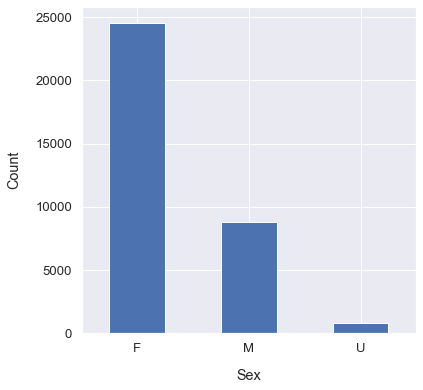

In [6]:
utils.barplot(patients['SEX'], "Sex")

## K-modes Clustering Model Implementation